In [1]:
import pandas as pd
import datetime as dt
import time
import requests
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

Problem Statement:

Can we develop a machine learning model that can predict, using Natural Language Processing, what subreddit a post originated from, given two similar options: the EDM subreddit, and the HipHopHeads subreddit.
Both subreddits are centered around contemporary music genres, and I am interested to see how effectively a model can distinguish between two subreddits this similar.


In [2]:
url = 'https://api.pushshift.io/reddit/search/submission'

In [3]:
params = {
    'subreddit': 'hiphopheads',
    'size': 500
}

In [4]:
res = requests.get(url, params)

In [5]:
res.status_code

200

In above code, I imported the push shift api, and checked with res.status_code to make sure it was successfully imported. 

In [6]:
def query_pushshift(subreddit, kind = 'submission', day_window = 7, n = 520):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    # establish base url and stem
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # also known as the "API endpoint" 
    stem = f"{BASE_URL}?subreddit={subreddit}&size=500" # always pulling max of 500
    
    # instantiate empty list for temp storage
    posts = [] 
    
    # implement for loop with `time.sleep(2)`
    for i in range(1, n + 1):
        URL = "{}&after={}d".format(stem, day_window * i)
        print("Querying from: " + URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        posts.append(df)
        time.sleep(2)
    
    # pd.concat storage list
    full = pd.concat(posts, sort=False)
    
    # if submission
    if kind == "submission":
        # select desired columns
        full = full[SUBFIELDS]
        # drop duplicates
        full.drop_duplicates(inplace = True)
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full.reset_index(drop=True)

results = query_pushshift('hiphopheads')

In [7]:
results.head(50)

In [8]:
results.shape

In [9]:
resultshiphopheads = results

I ran a function to scrape reddit.com/r/hiphopheads and was able to collect about 11,000 comments.

In [10]:
resultsedm = query_pushshift('EDM')

In [11]:
resultsedm.shape

I ran a function to scrape reddit.com/r/EDM and collected a similar amount of comments to hiphopheads, about 11,000.

In [12]:
resultsedm.to_csv('EDM.csv')

In [13]:
resultshiphopheads.to_csv('HipHopHeads.csv')

Here I save these dataframes to CSV so that if I were to close out this jupyter notebook, I would not have to rerun the scraping function to get these dataframes.

In [14]:
resultsedm = pd.read_csv('./EDM.csv')
resultshiphopheads = pd.read_csv('./HipHopHeads.csv')

DATA CLEANING AND EDA

In [15]:
resultshiphopheads.isnull().sum()

Unnamed: 0         0
title              0
selftext        1655
subreddit          0
created_utc        0
author             0
num_comments       0
score              0
is_self            0
timestamp          0
dtype: int64

In [16]:
dfhiphopheads = resultshiphopheads.dropna()

In [17]:
dfhiphopheads.isnull().sum()

Unnamed: 0      0
title           0
selftext        0
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

I check for null values in dfhiphopheads, and found only 60 null values in selftext. As such, I could most easily just drop these null values instead of filling them with something else, since I am left with still about 11,000 comments after dropping them.

In [18]:
resultsedm.isnull().sum()

Unnamed: 0        0
title             0
selftext        764
subreddit         0
created_utc       0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

In [19]:
dfedm = resultsedm.dropna()

In [20]:
dfedm.isnull().sum()

Unnamed: 0      0
title           0
selftext        0
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

I checked for null values in dfedm, and finding a similar result to dfhiphopheads, dropped the null values rather than fill them.

In [21]:
dfedm['from edm subreddit'] = 1
dfedm['from hiphopheads subreddit'] = 0

<ipython-input-21-432e5122bd30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfedm['from edm subreddit'] = 1
<ipython-input-21-432e5122bd30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfedm['from hiphopheads subreddit'] = 0


In [22]:
dfhiphopheads['from edm subreddit'] = 0
dfhiphopheads['from hiphopheads subreddit'] = 1

<ipython-input-22-56cefcb66474>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfhiphopheads['from edm subreddit'] = 0
<ipython-input-22-56cefcb66474>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfhiphopheads['from hiphopheads subreddit'] = 1


In [23]:
df = dfhiphopheads.append(dfedm)

In [24]:
df.shape

(19698, 12)

I added 'from edm subreddit' and 'from hiphophead subreddit' columns and dummified these columns. I then appended the two dataframes to one larger dataframe. The columns I added identifies which subreddit tbe information comes from. Now that they are all in the same dataframe I can run a train-test split on them and create a model.

In [25]:
df.head(20)

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,from edm subreddit,from hiphopheads subreddit
0,0,Stuck not know the song... help me!!,[removed],hiphopheads,1611118567,Bapeb2017,0,1,True,2021-01-19,0,1
1,1,Breaking: Trump has granted clemency to rapper...,Tweet mirror: https://imgur.com/a/WFNjJVA,hiphopheads,1611118844,halfmatthalfcat,0,1,True,2021-01-19,0,1
2,2,MF DOOM brief write up,Hey everyone! I've been spending my time latel...,hiphopheads,1611122645,kevvkevv,0,1,True,2021-01-19,0,1
3,3,Please comment my friend's song.,[removed],hiphopheads,1611123689,Competitive_Frame_88,0,1,True,2021-01-19,0,1
4,4,Dr. Carter saves World from Covid,After President Trump pardoned Weezy. He promp...,hiphopheads,1611127115,Skinsfan221,2,1,True,2021-01-19,0,1
5,5,Kodak Black - First Day Out,https://youtu.be/QoRgUlKxZ8M,hiphopheads,1611129972,trythiswithme,0,1,True,2021-01-20,0,1
6,6,Eminem: Higher,[removed],hiphopheads,1611130962,Amaya_8_8_8_Ocean,0,1,True,2021-01-20,0,1
7,7,Kodak and Lil Wayne’s Lawyer (Bradford Cohen) ...,"From a legal perspective, Kodak and Lil Wayne ...",hiphopheads,1611131523,Latrell-Sprewell,4,1,True,2021-01-20,0,1
8,8,"groovy song, new sound in my opinion :)",[removed],hiphopheads,1611131738,onlyguyouthere,0,1,True,2021-01-20,0,1
9,9,Rate Eminem Albums!,My ratings:\n\nInfinite:6/10\n\nSSLP:8.5/10\n\...,hiphopheads,1611133705,amhaka84,4,1,True,2021-01-20,0,1


In [26]:
print(df[df.selftext == '[removed]'].shape[0])
print(dfhiphopheads[dfhiphopheads.selftext == '[removed]'].shape[0])
print(dfedm[dfedm.selftext == '[removed]'].shape[0])
#https://stackoverflow.com/questions/35277075/python-pandas-counting-the-occurrences-of-a-specific-value

4482
2540
1942


I check how many times removed appears in the dataset, and it appears enough that I don't want to drop the rows with removed in it. Both subeddits have a similar amount of instance of removed, so I feel like it should not be too much of an issue for my model. I will instead, treat removed as a stop word in my count vectorizer.

In [179]:
df['title and selftext'] = df['title'] + df['selftext']
dfhiphopheads['title and selftext'] = dfhiphopheads['title'] + dfhiphopheads['selftext']
dfedm['title and selftext'] = dfedm['title'] + dfedm['selftext']

<ipython-input-179-04bbbbf0f57a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfhiphopheads['title and selftext'] = dfhiphopheads['title'] + dfhiphopheads['selftext']
<ipython-input-179-04bbbbf0f57a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfedm['title and selftext'] = dfedm['title'] + dfedm['selftext']


I create a new column that concatenates the title and selftext columns, so I can CountVectorize on the values of both columns. This is necessary because CountVectorize only works on a single column.

In [216]:
X = df['title and selftext']
y = df['from edm subreddit']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

In [218]:
my_words = ['com', 'www', 'https', 'http', 'removed']
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

In [219]:
cvec = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(stop_words))

In [220]:
X_train = cvec.fit_transform(X_train)

In [221]:
X_train.shape

(14773, 46196)

In [222]:
X_test = cvec.transform(X_test)

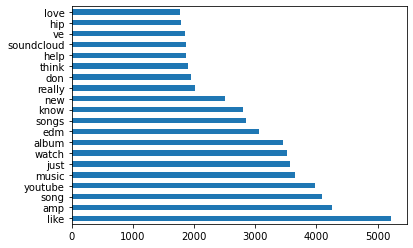

In [223]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');

I train test split, and fit my model, and then Count Vectorized X_train, to be able to see how often each word showed up in the title and selftext column. My count vectorizer function was acting up, returning a dataframe with the dimension [1,2]. So, I spent a while troubleshooting, and I realized it wouldn't work because I had put double brackets around my X_train when fitting the train test split.

In [264]:
y_train.value_counts(normalize = True)

1    0.521018
0    0.478982
Name: from edm subreddit, dtype: float64

Here I identify the null model. The classes seem to be more or less balanced, with .52 being from the edm subreddit, and .48 being from the hiphopheads subreddit. My model should outperform the null model.

In [224]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [225]:
pipe = Pipeline([
    ('cvec_2', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [226]:
pipe_params = {
    'cvec_2__max_features': [500, 1000, 5000, 10000],
    'cvec_2__min_df': [1, 2, 3],
    'cvec_2__max_df': [5, 10],
    'cvec_2__ngram_range': [(1,1), (1,2)]
}

In [227]:
bayes_model = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5, verbose = 1)

In [228]:
bayes_model.fit(X_train2, y_train2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_2', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec_2__max_df': [5, 10],
                         'cvec_2__max_features': [500, 1000, 5000, 10000],
                         'cvec_2__min_df': [1, 2, 3],
                         'cvec_2__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [230]:
bayes_model.score(X_train2, y_train2), bayes_model.score(X_test2, y_test2)

(0.7854815488368568, 0.7034302415013075)

In [232]:
preds_bayes = bayes_model.predict(X_test2)

In [234]:
tn, fp, fn, tp = confusion_matrix(y_test2, preds_bayes).ravel()

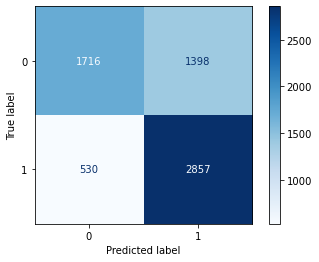

In [236]:
plot_confusion_matrix(bayes_model, X_test2, y_test2, cmap='Blues', values_format='d');

In [239]:
sensitivity = tp/(tp + fn)
print('Sensitivty ', sensitivity)

specificity = tn/(tn + fp)
print('Specificity ', specificity)

precision = tp/ (tp + fp)
print('Precision ', precision)

acc = (tn + tp) / (tn + fp + fn + tp)
print('Accuracy ', acc)

from sklearn.metrics import classification_report
print(classification_report(y_test2, preds_bayes))

Sensitivty  0.8435193386477708
Specificity  0.5510597302504817
Precision  0.6714453584018801
Accuracy  0.7034302415013075
              precision    recall  f1-score   support

           0       0.76      0.55      0.64      3114
           1       0.67      0.84      0.75      3387

    accuracy                           0.70      6501
   macro avg       0.72      0.70      0.69      6501
weighted avg       0.72      0.70      0.70      6501



Here I fit a bayes model on another X_train, as I count vectorized again when instantiating the pipeline. I ran a gridsearch on some hyperparameters, which I tweaked for a couple of times, and got an accuacy of 70%. The train score .78, and test score was .7, so there was not too much variance, and the bias of this model was medium.

In [244]:
bag_params = {
    'n_estimators': [5, 20, 25, 30, 40],
    'max_samples': [0.1, 0.2, 0.5, 0.75, 1],
    'max_features': [1,2,3,5],
    'bootstrap_features': [True, False]
}

In [245]:
gs_bag = GridSearchCV(bag, param_grid=bag_params, cv=5, n_jobs = -1, verbose = True)
gs_bag.fit(X_train, y_train)
print(gs_bag.best_score_)
gs_bag.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


0.5227103460047863


{'bootstrap_features': True,
 'max_features': 5,
 'max_samples': 0.5,
 'n_estimators': 20}

In [246]:
gs_bag.score(X_train, y_train), gs_bag.score(X_test, y_test)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


(0.5252826101671969, 0.5218274111675127)

In [247]:
preds_bag = gs_bag.predict(X_test)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


In [248]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_bag).ravel()

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


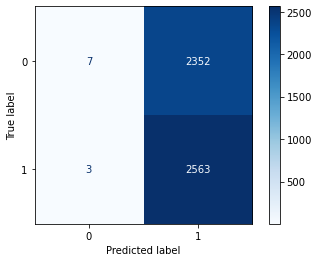

In [249]:
plot_confusion_matrix(gs_bag, X_test, y_test, cmap='Blues', values_format='d');

In [251]:
sensitivity = tp/(tp + fn)
print('Sensitivty ', sensitivity)

specificity = tn/(tn + fp)
print('Specificity ', specificity)

precision = tp/ (tp + fp)
print('Precision ', precision)

acc = (tn + tp) / (tn + fp + fn + tp)
print('Accuracy ', acc)

from sklearn.metrics import classification_report
print(classification_report(y_test, preds_bag))

Sensitivty  0.9988308651597818
Specificity  0.002967359050445104
Precision  0.5214649033570702
Accuracy  0.5218274111675127
              precision    recall  f1-score   support

           0       0.70      0.00      0.01      2359
           1       0.52      1.00      0.69      2566

    accuracy                           0.52      4925
   macro avg       0.61      0.50      0.35      4925
weighted avg       0.61      0.52      0.36      4925



I decided to run a few more models to try and improve my Naive Bayes Model's score. Here I ran a bags model, where I gridsearched through hyperparamters, and still got a very horrible accuracy score of 0.52. The true positives (sensitivity) was near 100%, while the true negatives (specificity) was near 0%, which would seem to indicate a class imbalance, and the model predicting the majority class. However, the classes were not really that imbalanced, so I am not sure exactly what made the model go wrong. I adjusted hyperparameters a bit, but ended up moving onto another model after getting dismal results.

In [256]:
rf = RandomForestClassifier(random_state = 42)

In [257]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto', 'log2']
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs = -2, verbose = True)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 170 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-2)]: Done 420 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-2)]: Done 540 out of 540 | elapsed:  1.0min finished


0.668447704050947


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 100}

In [259]:
gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)

(0.63710823800176, 0.6339086294416244)

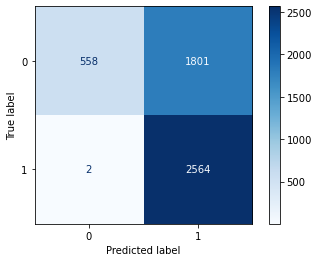

In [260]:
preds_rf = gs_rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Blues', values_format='d');

In [261]:
sensitivity = tp/(tp + fn)
print('Sensitivty ', sensitivity)

specificity = tn/(tn + fp)
print('Specificity ', specificity)

precision = tp/ (tp + fp)
print('Precision ', precision)

acc = (tn + tp) / (tn + fp + fn + tp)
print('Accuracy ', acc)


Sensitivty  0.9992205767731879
Specificity  0.23654090716405257
Precision  0.5873997709049256
Accuracy  0.6339086294416244


The final model I ran was random forest classifier, gridsearched through hyperparameters, and iteratively tweaked them. The model returned an accuracy of 63%, a train score of .63 and a test score of .63, indicating the model was very low variance but high bias. It is better than the null model, but worse than the Bayes model.

CONCLUSION:
My Naive Bayes model had a predictive accuracy of about 70%. This is statistically significant enough to say that we have created a model that can predict better than random chance, what subreddit a given post originated from.
Given the highly correlated nature of the subreddits, this is not too bad. However, the model is still less effective than I would have liked. 

WAYS TO IMPROVE MY MODEL:
To improve my model in the future I could:
Lemmatize.
Add more words to stop words, particularly those ones that are most shared between subreddits.
Run more models, in particular voting classifier.
Tinker with hyperparameters.
Fit X_train on more features, including posting time.